# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [ ]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
import scipy as sc
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os

## Generating the data

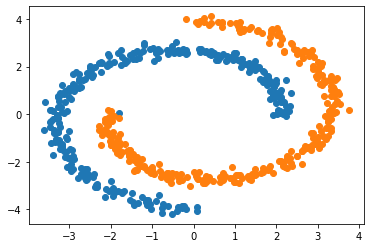

In [ ]:
# Example

for fn in [two_moons]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.:
worst_case_blob?

## Building similarity graph

In [ ]:
def similarity(x, y, var=1.0):
    return np.exp(- np.linalg.norm(x - y)**2 / (2*var))

In [ ]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0):
    """
    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
  
    similarities = np.eye(n)
    for ii in range(n):
        for jj in range(ii):
            similarities[ii,jj] = similarity(X[ii], X[jj], var)
            similarities[jj,ii] = similarities[ii, jj]

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        for ii in range(n):
            for jj in range(ii):
                if similarities[ii, jj] > eps:
                    W[ii, jj] = similarities[ii, jj]
                    W[jj, ii] = similarities[ii, jj]

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        for ii in range(n):
            similarities[ii, ii] = 0.0
            neighbors = np.argsort(similarities[ii, :])[::-1][:k]
            for jj in neighbors:
                W[ii,jj] = similarities[ii,jj]
                W[jj,ii] = similarities[ii,jj]

    return W


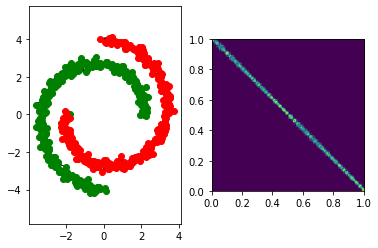

In [ ]:
# Example

W = build_similarity_graph(X, eps=0.9, k= 10)
# W[0, 599] = 1    # for example, to visualize below
# W[10, 500] = 1   # 


plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

## Computing the Laplacian

In [ ]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    n = W.shape[0]
    L = np.zeros((n,n))
    D = np.diag(np.sum(W, axis=1))

    if laplacian_normalization == 'unn':
        L = D-W
    elif laplacian_normalization == 'sym':
        D_inv = np.linalg.inv(D)
        D_inv_sqrt = D_inv ** 0.5
        L = np.eye(n) - D_inv_sqrt @ W @ D_inv_sqrt
    elif laplacian_normalization == 'rw':
        D_inv = np.linalg.inv(D)
        L = np.eye(n) - D_inv @ W

    return L

In [ ]:
L = build_laplacian(W)
L

array([[11.67567623, -0.94995907, -0.96886942, ...,  0.        ,
         0.        ,  0.        ],
       [-0.94995907,  9.66817886, -0.95207597, ...,  0.        ,
         0.        ,  0.        ],
       [-0.96886942, -0.95207597,  9.56672484, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  8.54979763,
        -0.94161643, -0.93514007],
       [ 0.        ,  0.        ,  0.        , ..., -0.94161643,
         9.55393727, -0.99252633],
       [ 0.        ,  0.        ,  0.        , ..., -0.93514007,
        -0.99252633,  9.43369384]])

## Clustering

In [ ]:
def spectral_clustering(L, chosen_eig_indices=None, num_classes=2):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    eigvals, eigvects = sc.linalg.eig(L)
    # eigvals, eigvect = sc.sparse.linalg.eigs(L)

    eigvals, eigvects = eigvals.real, eigvects.real
    order = np.argsort(eigvals)
    eigvals = eigvals[order]

    E = np.diag(eigvals)
    U = eigvects[:,order]

    """
    Compute the eigen gaps and choose the good number of eigenvalues
    """
    if chosen_eig_indices is None:
        eiggaps = np.zeros(eigvals.shape[0]-1)
        for k in range(1,eigvals.shape[0]-1):
            eiggaps[k] = (eigvals[k+1] - eigvals[k])/ (eigvals[k]+1e-6)
        num_classes = np.argmax(eiggaps)+1
        print(num_classes, ' classes found')
        chosen_eig_indices = np.arange(0, min(eigvals.shape[0], num_classes))
        
    U = U[:, chosen_eig_indices]

    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    kms = KMeans(num_classes)
    Y = kms.fit_predict(U)
    return Y

2  classes found


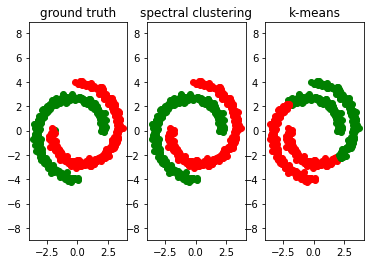

In [ ]:
# Example

num_classes = 2
L = build_laplacian(W)
# Y_rec = spectral_clustering(L, chosen_eig_indices=[0,1,2], num_classes=num_classes)
Y_rec = spectral_clustering(L, num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity 

In [ ]:
def parameter_sensitivity(parameter_candidate=[], param_type='eps'):
    """
    A function to test spectral clustering sensitivity to parameter choice.
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 1.0  # exponential_euclidean's sigma^2
    laplacian_normalization = 'unn'
    chosen_eig_indices = None

    """
    Choose candidate parameters
    """
    # parameter candidates the number of neighbours for the graph or the epsilon threshold
    parameter_performance = []

    for param in parameter_candidate:
        # Generate data
        X, Y = two_moons(num_samples, 1, 0.02)
        num_classes = len(np.unique(Y))

        if param_type == 'eps':
            W = build_similarity_graph(X, eps=param)
        else:
            W = build_similarity_graph(X, eps=0, k=param)
        L = build_laplacian(W, laplacian_normalization)

        Y_rec = spectral_clustering(L, num_classes=num_classes, chosen_eig_indices=[0,1])

        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

    plt.figure()
    plt.plot(parameter_candidate, parameter_performance)
    plt.title('parameter sensitivity')
    plt.show()

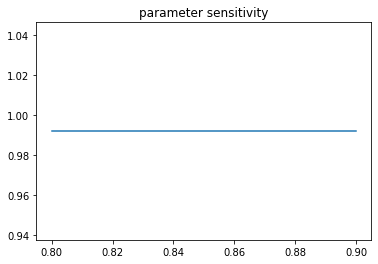

In [ ]:
parameter_sensitivity([0.8,0.85,0.9])

## Image segmentation

In [ ]:
def image_segmentation(input_img='four_elements.bmp'):
    """
    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """
    var = 1.0
    k = 15
    laplacian_normalization = 'unn'
    # chosen_eig_indices = None
    # chosen_eig_indices = [1,2,3,4,5]
    chosen_eig_indices = [1,2,3,4]
    num_classes = 4

    W = build_similarity_graph(Xr, var=var, k=k)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()

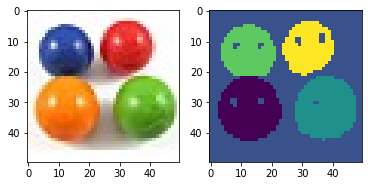

In [ ]:
# k=15
# chosen_eig_indices = [1,2,3,4,5]
image_segmentation()

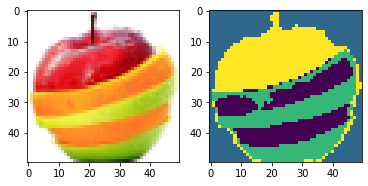

In [ ]:
image_segmentation('fruit_salad.bmp')

# Questions

### Q1: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph. 

It is important to build a connected graph. Indeed, if we take the extreme example of a completely unconnected graph, one looses all the information contained in the nodes. To a lesser extent, highly unconnected graphs will tend to create many connected components, and spectral clustering will fail to cluster according to the main components. 

To guarantee connectivity, one must choose:
- $\epsilon = ((\log N)/N)^d$ in $\epsilon$-graphs
- $k \approx \log N$ in k-NN graphs

We observe that both graphs have different characteristics with respect to the difficulty of building a connected graph:
- the $\epsilon$-graph needs to have a low $\epsilon$ value to connect more nodes, and for a component to be connected, one must have $\epsilon$ lower to the lowest similarity between two points of the component. The difficulty lies in the fact that one must not choose $\epsilon$ too high, otherwise points of different clusters might connect between each other. Therefore, if the distances between data points are at different scales in different clusters, it would be impossible to create a good $\epsilon$-graph, because one would have to choose $\epsilon$ low enough to connect points of the clusters that are at a big scale, but high enough not to connect the points between different clusters.

- the k-NN graphs needs to have a high $k$ value to connect nodes together. The above problem of clusters at different scales would not happen as much as in $\epsilon$-neighborhood graph, because it would allow points of a low-density cluster to be connected just as much as the ones from a high-density cluster. The k-NN is also able to create good clusters where the density and the number of points are high. However, it doesn't deal as well with clusters that have less points or with outliers, since it would create bad connections between a point belonging to the small cluster, and a point rather far away belonging to another one.

To showcase what has been said before, here are 2 examples:
- in the first one, one cluster contains much more points than the 2 others. The $\epsilon$-graph is more suited to created a connected graph than the k-NN one.

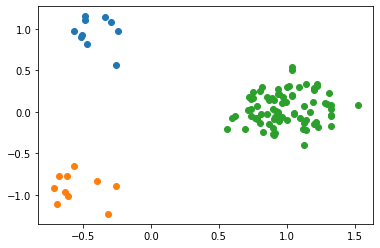

k-NN graph for k=9


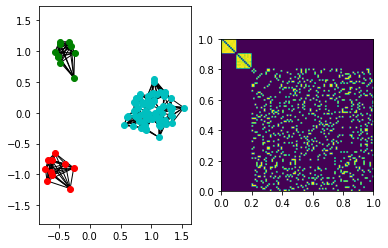

k-NN graph for k=20


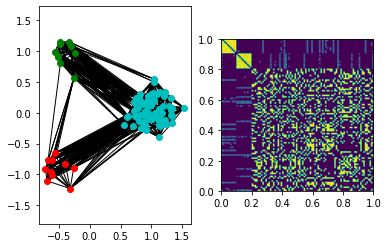

epsilon graph for eps=0.9


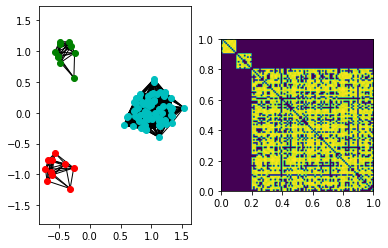

In [ ]:
X, Y = blobs(n_blobs=3, num_samples=100, surplus=70, blob_var=0.2)
plot_clusters(X, Y, fignum=str(fn), show=True)

print('k-NN graph for k=9')
W = build_similarity_graph(X, eps=0., k= 9)
plot_graph_matrix(X, Y, W) 

print('k-NN graph for k=20')
W = build_similarity_graph(X, eps=0., k= 20)
plot_graph_matrix(X, Y, W) 

print('epsilon graph for eps=0.9')
W = build_similarity_graph(X, eps=0.9)
plot_graph_matrix(X, Y, W) 

- in the second one, the 2 clusters are at different scales. The $\epsilon$-graph is less suited to created a connected graph than the k-NN one.

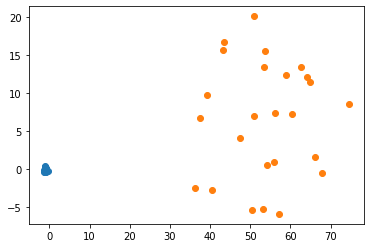

k-NN graph for eps=0.9


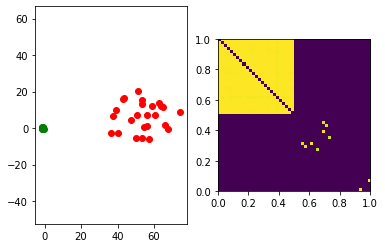

k-NN graph for eps=0.1


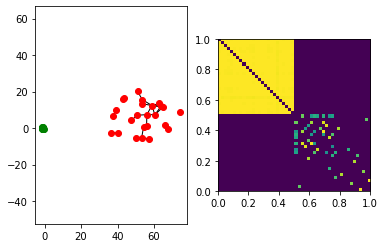

epsilon graph for k=20


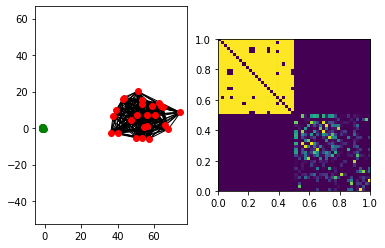

In [ ]:
X, Y = blobs(n_blobs=2, num_samples=50, surplus=0, blob_var=0.2)
for ii in range(len(X)):
  if X[ii][0] > 0: 
      X[ii] = 4+50*X[ii]

plot_clusters(X, Y, fignum=str(fn), show=True)

print('k-NN graph for eps=0.9')
W = build_similarity_graph(X, var=30.0, eps=0.9)
plot_graph_matrix(X, Y, W) 

print('k-NN graph for eps=0.1')
W = build_similarity_graph(X, var=30.0, eps=0.5)
plot_graph_matrix(X, Y, W) 

print('epsilon graph for k=20')
W = build_similarity_graph(X, var=30.0, eps=0.9, k=20)
plot_graph_matrix(X, Y, W) 

### Q2: The function `min_span_tree` can be used to choose the value of $\epsilon$ that keeps the graph connected. Using the `worst_case_blob`, can you tell when it is a bad idea to use this approach?

The function `min_span_tree` can be used to choose the value of $\epsilon$ that keeps the graph connected, by computing the min spanning tree and choosing the minimum similarity needed to ensure that the graph is connected.

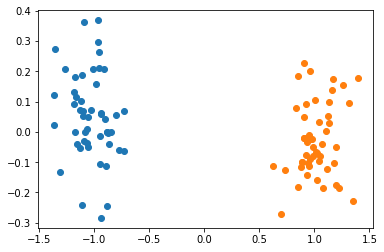

epsilon graph for eps=0
epsilon graph for eps= 0.39707340379837913


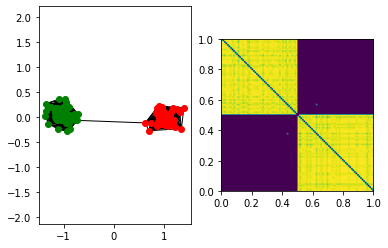

In [ ]:
X, Y = blobs(n_blobs=2, num_samples=100, surplus=0, blob_var=0.15)
plot_clusters(X, Y, fignum=str(fn), show=True)
print('epsilon graph for eps=0')
W = build_similarity_graph(X, eps=0)
epsilon = np.min(W[np.where(min_span_tree(1-W))])-1e-6
print('epsilon graph for eps=',epsilon)
W = build_similarity_graph(X, eps=epsilon)
plot_graph_matrix(X, Y, W) 

It is a bad idea to use this method when there are outliers. Indeed, when there is an outlier, its similarity to every other point will be low (close to $0$), so the minimum epsilon needed to create a connected graph will be low too, leading to a fully-connected graph. (This could be an issue if we want a sparse graph for efficient computations.)

This can be pointed out by using the `worst_case_blob` function and by changing the *delta* parameter that controls how far away is the outlier.

 --- Normal Case ---


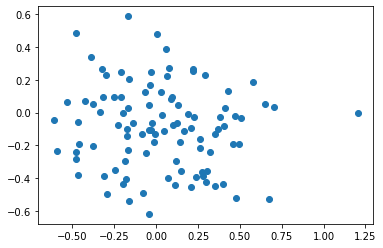

epsilon graph for eps= 0.8819688435862031


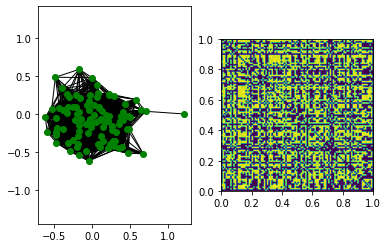


  --- Outlier Case ---


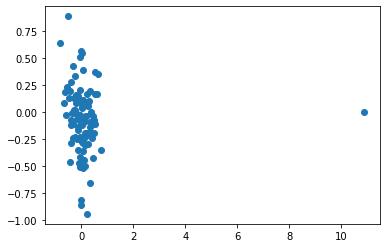

epsilon graph for eps= -1e-06


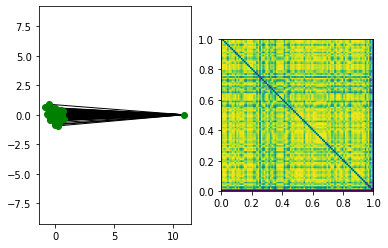

In [ ]:
print(' --- Normal Case ---')
X, Y = worst_case_blob(num_samples=100, delta=0.5)
plot_clusters(X, Y, fignum=str(fn), show=True)
W = build_similarity_graph(X, eps=0)
epsilon = np.min(W[np.where(min_span_tree(1-W))])-1e-6
print('epsilon graph for eps=',epsilon)
W = build_similarity_graph(X, eps=epsilon)
plot_graph_matrix(X, Y, W) 

print('\n', ' --- Outlier Case ---')
X, Y = worst_case_blob(num_samples=100, delta=10.0)
plot_clusters(X, Y, fignum=str(fn), show=True)
W = build_similarity_graph(X, eps=0)
epsilon = np.min(W[np.where(min_span_tree(1-W))])-1e-6
print('epsilon graph for eps=',epsilon)
W = build_similarity_graph(X, eps=epsilon)
plot_graph_matrix(X, Y, W) 

### Q3: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

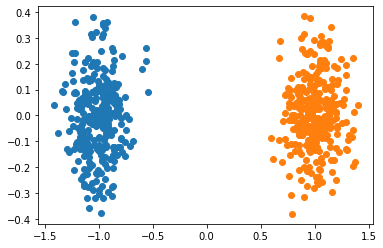

epsilon graph for eps= 0.5128866630673728


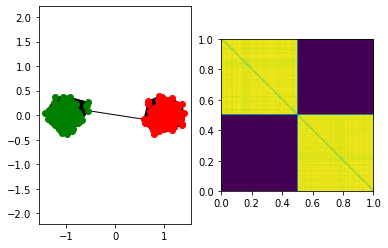

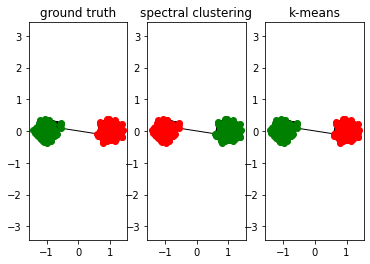

In [ ]:
X, Y = blobs(num_samples=600)
plot_clusters(X, Y, show=True)

W = build_similarity_graph(X, eps=0)
epsilon = np.min(W[np.where(min_span_tree(1-W))])-1e-6
print('epsilon graph for eps=',epsilon)
W = build_similarity_graph(X, eps=epsilon)
plot_graph_matrix(X, Y, W) 

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[0,1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))


We can use the first $k$ eigen-vectors, where $k$ is the number of clusters, as seen in class, and then use KMeans clustering on these vectors to assign $k$ clusters (here $k=2$).
The results are exactly the same between KMeans and spectral clustering, which is expected since the case is relatively simple for KMeans.

### Q4: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

To automatically select the eigenvectors to use and the number of classes, we can compute each eigen gap (i.e. the gap between 2 consecutive eigen values) and divide it by the previous eigen value. Therefore we compute for each $k$ the value of $(\lambda_{k+1}-\lambda_k)/\lambda_k$. Then, we check where this value is maximum, meaning that the eigen gap is relatively high, while the considered eigen value is relatively small (close to 0). That way, we can retrieve the number of $\approx 0$ eigen values, that is to say, the number of connected components. 

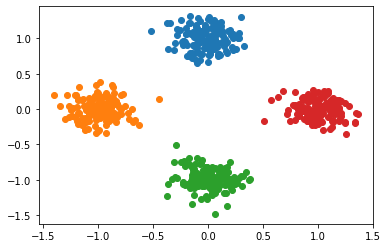

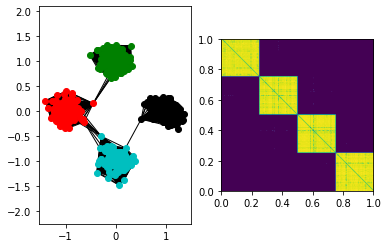

4  classes found


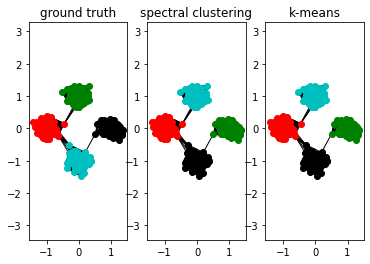

In [ ]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.15)
plot_clusters(X, Y, show=True)

W = build_similarity_graph(X, eps=0)
epsilon = np.min(W[np.where(min_span_tree(1-W))])-1e-6
W = build_similarity_graph(X, eps=epsilon)
plot_graph_matrix(X, Y, W) 

num_classes = 4
L = build_laplacian(W)
Y_rec = spectral_clustering(L, num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

The same procedure can be repeted for blobs of different variance. We can see that the automatic procedure to find $k$ is relatively robust to variance but fails to reproduce clusters when they are too mixed up.

--- Var=0.3


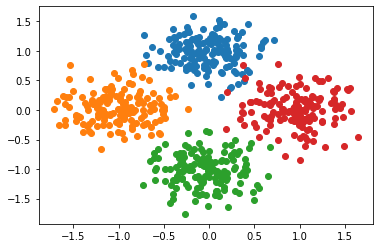

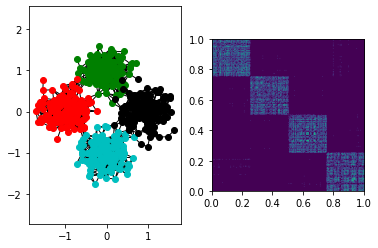

4  classes found


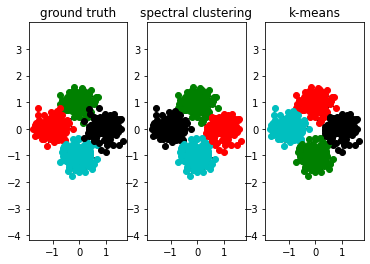

--- Var=0.6


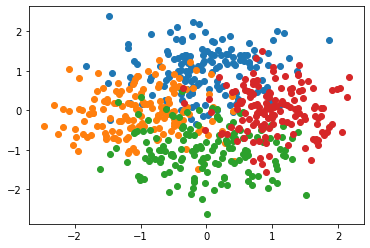

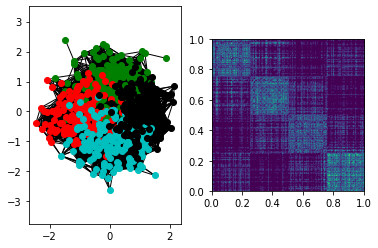

3  classes found


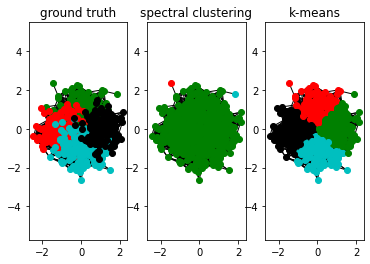

In [ ]:
print('--- Var=0.3')
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.3)
plot_clusters(X, Y, show=True)

W = build_similarity_graph(X, eps=0)
epsilon = np.min(W[np.where(min_span_tree(1-W))])-1e-6
W = build_similarity_graph(X, eps=epsilon)
plot_graph_matrix(X, Y, W) 

num_classes = 4
L = build_laplacian(W)
Y_rec = spectral_clustering(L, num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

print('--- Var=0.6')
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.6)
plot_clusters(X, Y, show=True)

W = build_similarity_graph(X, eps=0)
epsilon = np.min(W[np.where(min_span_tree(1-W))])-1e-6
W = build_similarity_graph(X, eps=epsilon)
plot_graph_matrix(X, Y, W) 

num_classes = 4
L = build_laplacian(W)
Y_rec = spectral_clustering(L, num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

### Q5: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

The cluster assignement was built using only K-Means, which is more general than thresholding and can be used when dealing with more than 1 dimension vectors. We can note than thresholding might be more efficient when there are only 2 classes.

### Q6: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

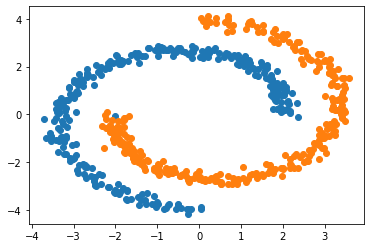

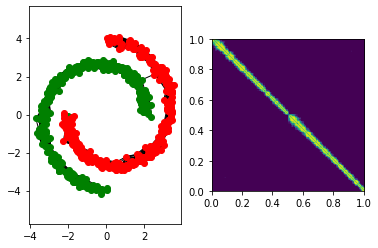

2  classes found


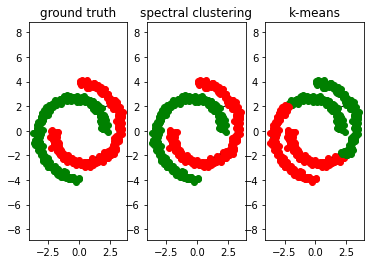

In [ ]:
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)

W = build_similarity_graph(X, eps=0)
epsilon = np.min(W[np.where(min_span_tree(1-W))])-1e-6
W = build_similarity_graph(X, eps=epsilon)
plot_graph_matrix(X, Y, W) 

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

As expected, the spectral clustering gives a more satisfying result than KMeans and achieves to assign the original 2 clusters, while KMeans is not able to. This is explainable by the fact that the graph structure generated by the $\epsilon$-graph neighborhood is able to capture local neighborhoods and recreate 2 main connected components. On the contrary, KMeans can not work here because 2 points that are close together might not belong to the same half-moon. 

### Q7: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

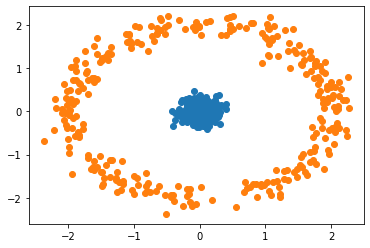

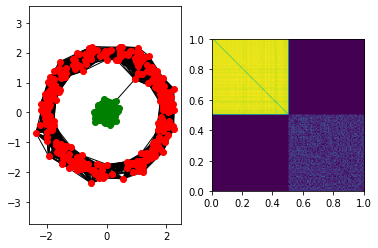

--- Using normal Laplacian ---
2  classes found


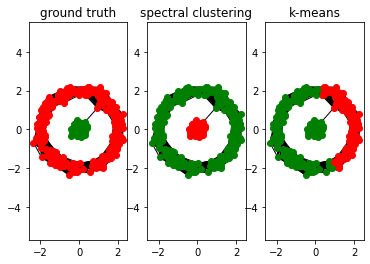

--- Using random-walk regularized Laplacian ---
2  classes found


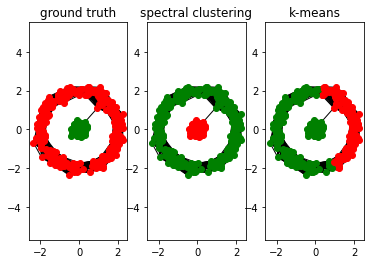

In [ ]:
X, Y = point_and_circle(num_samples=600)
plot_clusters(X, Y)

W = build_similarity_graph(X, eps=0)
epsilon = np.min(W[np.where(min_span_tree(1-W))])-1e-6
W = build_similarity_graph(X, eps=epsilon)
plot_graph_matrix(X, Y, W) 

num_classes = 2

print('--- Using unnormalized Laplacian ---')
L = build_laplacian(W)
Y_rec = spectral_clustering(L, num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

print('--- Using random-walk regularized Laplacian ---')
L = build_laplacian(W, laplacian_normalization='rw')
Y_rec = spectral_clustering(L, num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

Here, there is no difference between rw regularized Laplacian and usual Laplacian. First, it makes sense that the spectral clustering works here, because the graph structure recreates 2 main components. (As there is no difference between both Laplacians, I don't really know what is expected concerning the comparison of the 2)

### Q8: Using the function `parameter_sensitivity`, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

The function `parameter_sensitivity` allows to reproduce the same experiment but with varying parameters. We are then able to compare the accuracy obtained for different values of these parameters. The experiment consists in assigning 2 clusters to the half-moon data, using spectral clustering with unnormalized Laplacian. 

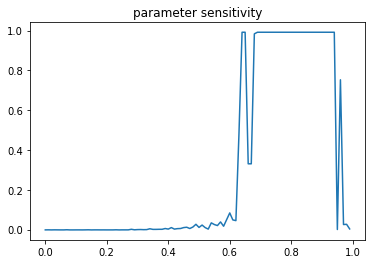

In [ ]:
parameter_sensitivity([0.01*i for i in range(100)], param_type='eps')

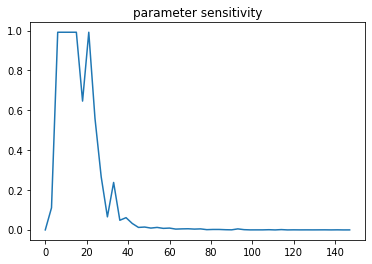

In [ ]:
parameter_sensitivity([3*i for i in range(50)], param_type='k')

As we can see above, both parameters approximately behave the same way. For a too small value, the accuracy isn't good and it improves as the neighborhoods get bigger ($\epsilon$ decreases or $k$ increases). However, if the neighborhoods get too big, then the graph structure fails to capture discriminative connections between the clusters, and begin being too connected. In this case, all the points are connected and similar, so the algorithm fails to discriminate them, resulting in a bad accuracy. 

### Q9: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

If we have not access to "true" labels, then we should not use usual losses such as MSE with arbitrary labels. Indeed, an algorithm that gives label 0 to the original cluster 1 and label 1 to the original cluster 0 is a good algorithm, but it could be interpreted as terrible by an MSE loss with labels 0 and 1.

One way to evaluate a clustering result is with modularity. It was designed to measure the strength of division of a network into clusters. Modularity is the fraction of the edges that fall within the given groups minus the expected fraction if edges were distributed at random.

Another way is to have a metric that measures if a cluster has a small intra variability and to have a metric that measures how well the clusters are separated between each other. 
For instance, assume the data have been clustered into k clusters. One way to evaluate cluster $C$ is by $d_{intra}(i)=\sum_{i \in C}\sum_{j\neq i \in C} d(i,j) / \vert C\vert(\vert C\vert-1) $ that computes the average distance in the cluster. To evaluate how well 2 clusters are separated, we can look at $d_{inter}(i)=\min_{i\in C_1, j\in C_2} d(i,j)$. Then if all the $d_{intra}(i)$ are inferior to all the $d_{inter}(j)$ for $j\neq i$, it means that the clusters are good to separate the data.

### Q10: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

- The first simple technique that could be used is to reduce the resolution of the image to get back to a computational friendly problem, but it might not be what is expected in the answer. An evolution of this approach would consist in downsampling the problem by deleting nodes of the graph (pixels of the image) that are too similar, as we construct it. For instance, only take some points of that are of the same color in a neighborhood. It would lead to a sparse graph with less nodes that can be efficiently used for spectral clustering.

- Another approach would consist in using approximations for computations (for the graph construction and eigen value decomposition), such as LSH- Locally Sensitive Hashing, Cover Trees or Spectral sparsifiers.